# Parte 1 — Análisis de Series de Tiempo
**C7 IA Innovador**  
**Ing:** Engler González · **Objetivo:** dejar la serie lista para modelar


## 0) Dependencias y objetivo de la celda
En esta celda importamos librerías y definimos el objetivo del bloque: cargar una serie real (CO₂ Mauna Loa) o, si no está disponible, generar una serie sintética mensual.


In [2]:

# import numpy as np, pandas as pd, matplotlib.pyplot as plt  -> librerías base para manipular y graficar datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Intentaremos cargar un dataset real de statsmodels; si falla, generamos datos sintéticos
dataset_name = None
try:
    import statsmodels.api as sm  # librería de modelos estadísticos
    co2 = sm.datasets.co2.load_pandas().data.copy()   # dataset CO₂ (ppm)
    co2.index = pd.to_datetime(co2.index)             # aseguramos índice datetime
    y = co2['co2'].resample('MS').mean().ffill()      # resampleo a mensual (MS) y forward-fill
    df = pd.DataFrame({'y': y})                       # dataframe final con una sola columna y
    dataset_name = 'NOAA Mauna Loa CO₂ (ppm) — statsmodels'
except Exception as e:
    # Fallback sintético: tendencia + estacionalidad + ruido (120 meses ~10 años)
    idx = pd.date_range('2016-01-01', periods=120, freq='MS')
    rng = np.random.default_rng(7)                    # generador de aleatoriedad reproducible
    trend = np.linspace(100, 220, len(idx))           # tendencia creciente
    season = 12 * np.sin(2*np.pi*(idx.month/12.0))    # estacionalidad anual (m=12)
    noise = rng.normal(0, 2.2, len(idx))              # ruido gaussiano
    y = trend + season + noise
    df = pd.DataFrame({'y': y}, index=idx)
    dataset_name = 'Serie sintética (ventas mensuales aprox.)'

df.index.name = 'ds'                                   # nombramos el índice como ds (datestamp)
print(f'Dataset: {dataset_name} | Observaciones: {df.shape[0]} | Frecuencia inferida: {pd.infer_freq(df.index)}')
df.head()


Dataset: NOAA Mauna Loa CO₂ (ppm) — statsmodels | Observaciones: 526 | Frecuencia inferida: MS


,y
ds,
1958-03-01,316.100000
1958-04-01,317.200000
1958-05-01,317.433333
1958-06-01,317.433333
1958-07-01,315.625000


## 1) Visualización inicial
Vamos a graficar la serie original para buscar señales de tendencia/estacionalidad.


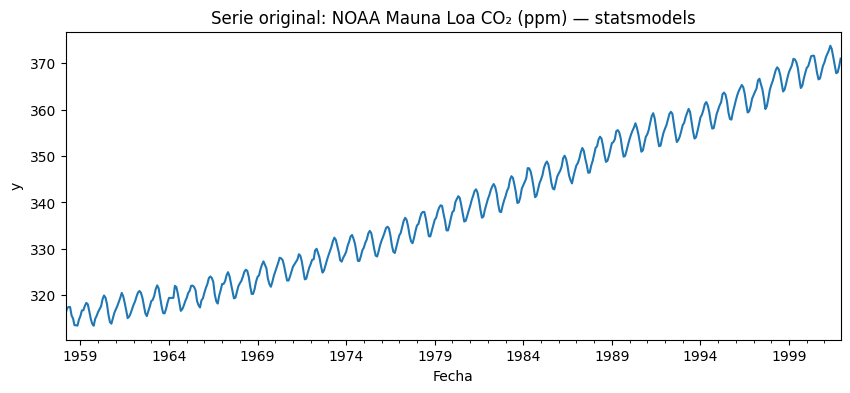

In [3]:
ax = df['y'].plot(figsize=(10,4), title=f'Serie original: {dataset_name}')
ax.set_xlabel('Fecha'); ax.set_ylabel('y')
plt.show()


## 2) Agregaciones y chequeos rápidos
- Contar valores faltantes y rellenar si los hay.
- Ver **promedio anual** (para ver tendencia) y **promedio por mes** (estacionalidad).


Valores faltantes: 0


/tmp/ipython-input-2913905649.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  y_year = df['y'].resample('Y').mean()


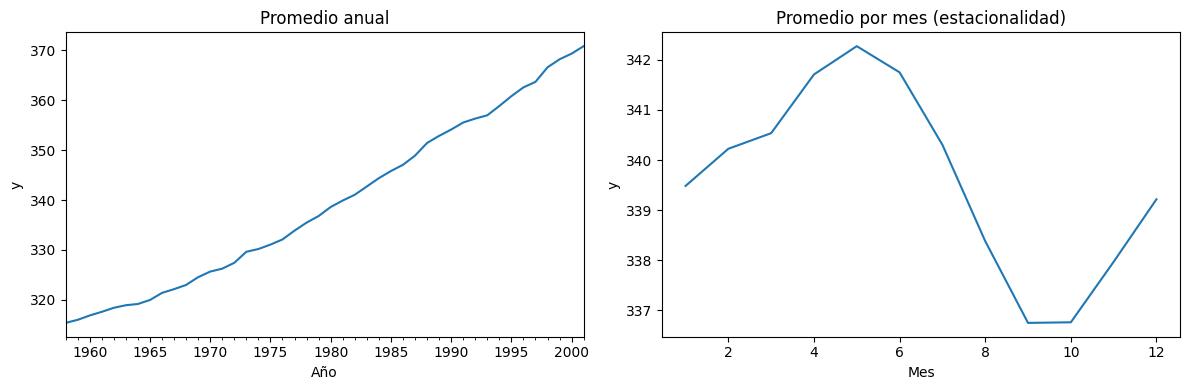

In [4]:
print("Valores faltantes:", df['y'].isna().sum())
df['y'] = df['y'].interpolate('time')  # imputación suave por tiempo

# Agregaciones
y_year = df['y'].resample('Y').mean()
y_month = df['y'].groupby(df.index.month).mean()

fig, axes = plt.subplots(1,2, figsize=(12,4))
y_year.plot(ax=axes[0], title='Promedio anual')
axes[0].set_xlabel('Año'); axes[0].set_ylabel('y')
y_month.plot(ax=axes[1], title='Promedio por mes (estacionalidad)')
axes[1].set_xlabel('Mes'); axes[1].set_ylabel('y')
plt.tight_layout(); plt.show()


## 3) Descomposición de la serie
Probamos **modelo aditivo** y **multiplicativo** con periodo estacional m=12 para separar tendencia, estacionalidad y residuo.


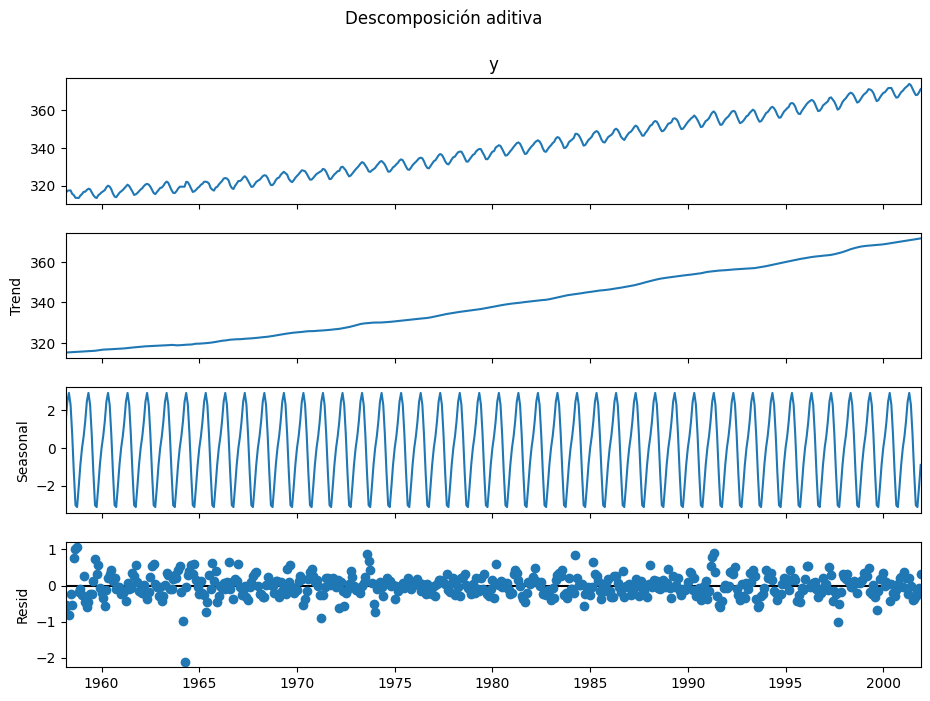

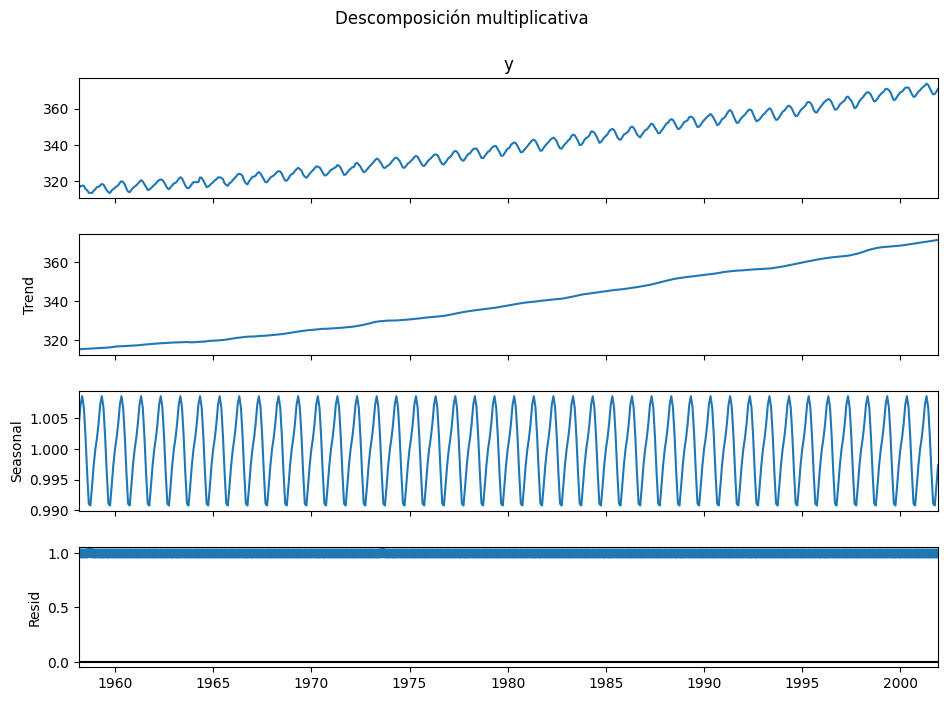

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

m = 12
res_add = seasonal_decompose(df['y'], model='additive', period=m, extrapolate_trend='freq')
fig = res_add.plot(); fig.set_size_inches(10,7); plt.suptitle('Descomposición aditiva', y=1.02); plt.show()

res_mul = seasonal_decompose(df['y'], model='multiplicative', period=m, extrapolate_trend='freq')
fig = res_mul.plot(); fig.set_size_inches(10,7); plt.suptitle('Descomposición multiplicativa', y=1.02); plt.show()


## 4) Estacionariedad (ADF) y transformaciones
- Ejecutamos **ADF**: p<0.05 ⇒ estacionaria.  
- Si `y>0`, probamos `log(y)` y **diferencia** d=1.  
- Luego veremos ACF y PACF sobre la serie diferenciada.


ADF y (original): stat=2.285 | p=0.9989 | H0: NO estacionaria
ADF log(y): stat=1.925 | p=0.9986 | H0: NO estacionaria
ADF diff1: stat=-5.118 | p=0.0000 | H0: NO estacionaria


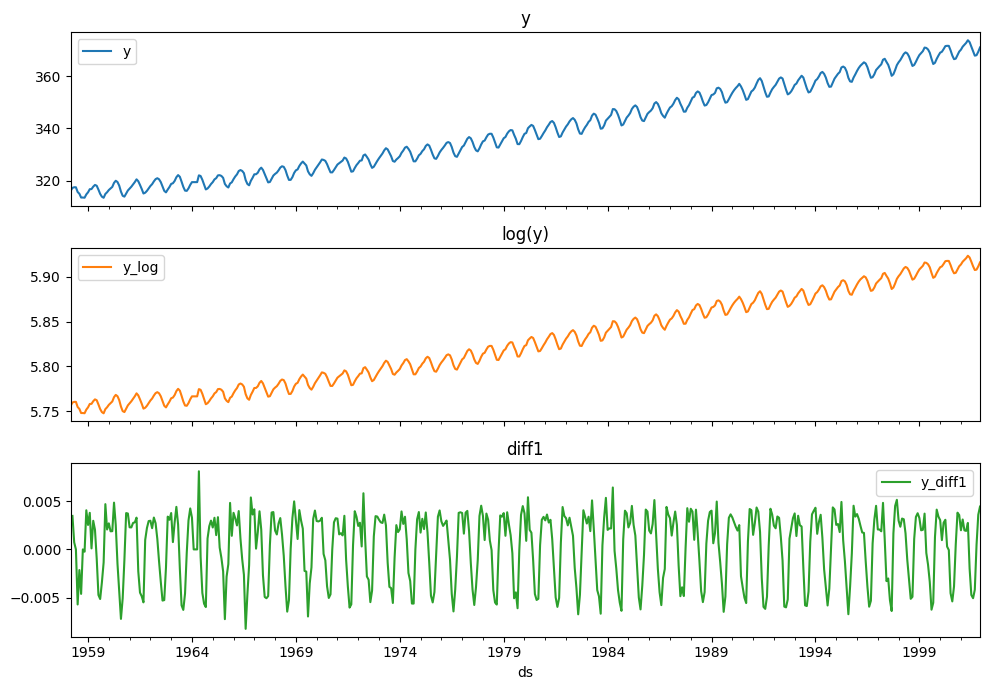

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_report(s, name):
    s = s.dropna()
    stat, p, *_ = adfuller(s)
    print(f'ADF {name}: stat={stat:.3f} | p={p:.4f} | H0: NO estacionaria')

adf_report(df['y'], 'y (original)')

df_t = df.copy()
if (df['y']>0).all():
    df_t['y_log'] = np.log(df['y'])
    adf_report(df_t['y_log'], 'log(y)')
else:
    df_t['y_log'] = np.nan

base = df_t['y_log'] if df_t['y_log'].notna().all() else df_t['y']
df_t['y_diff1'] = base.diff(1)
adf_report(df_t['y_diff1'], 'diff1')

ax = df_t[['y','y_log','y_diff1']].plot(subplots=True, figsize=(10,7), title=['y','log(y)','diff1'])
plt.tight_layout(); plt.show()


## 5) ACF y PACF (guías visuales para ARIMA)
Usamos la serie diferenciada para inspeccionar rezagos significativos.


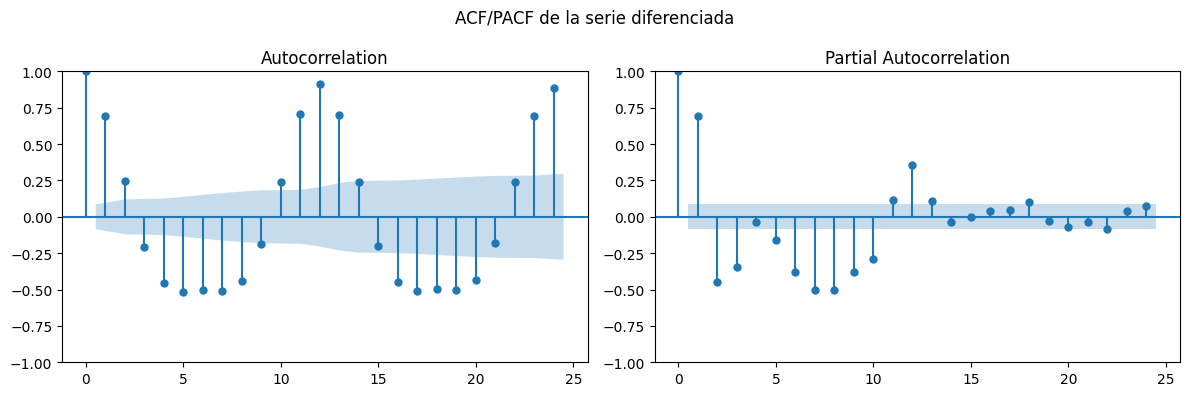

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
series = (df_t['y_log'] if df_t['y_log'].notna().all() else df_t['y']).diff().dropna()

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1); plot_acf(series, lags=24, ax=ax1)
ax2 = plt.subplot(1,2,2); plot_pacf(series, lags=24, ax=ax2, method='ywm')
plt.suptitle('ACF/PACF de la serie diferenciada'); plt.tight_layout(); plt.show()


## 6) Guardar salida para la Parte 2
Guardamos CSV con `y` y, si corresponde, `log(y)`.


In [ ]:
out_csv = 'serie_preprocesada_parte2.csv'
to_save = df.copy()
if 'y_log' in df_t.columns:
    to_save['y_log'] = df_t['y_log']
to_save.to_csv(out_csv, index=True)
print('Guardado:', out_csv)
to_save.tail()


---
## Reto (Parte 1)
1. Resamplea la serie a **semanal (W)** y grafica.  
2. Calcula estacionalidad por **día de la semana** (1..7) y compárala con la estacionalidad **mensual**.  
3. Escribe **3 conclusiones** sobre las diferencias.

### Solución

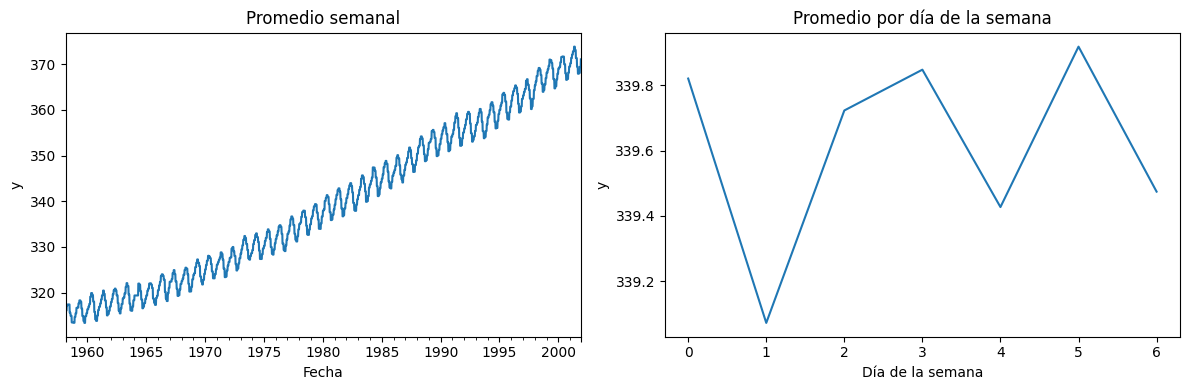

In [11]:
# 1) Resampleo semanal

# y_week = df['y'].resample('W').mean() # Original line
y_week = df['y'].resample('W').mean().ffill() # Resample to weekly and forward-fill NaNs

# 2) Estacionalidad por día de la semana (0=lun … 6=dom)

by_dow = df['y'].groupby(df.index.dayofweek).mean()
by_month = df['y'].groupby(df.index.month).mean()

fig, axes = plt.subplots(1,2, figsize=(12,4))
y_week.plot(ax=axes[0], title='Promedio semanal')
axes[0].set_xlabel('Fecha'); axes[0].set_ylabel('y')
by_dow.plot(ax=axes[1], title='Promedio por día de la semana')
axes[1].set_xlabel('Día de la semana'); axes[1].set_ylabel('y')
plt.tight_layout(); plt.show()